In [1]:
import os

import numpy as np
import tensorflow as tf

In [2]:
def load_data(path):
    x = None
    for filename in os.listdir(path):
        with open(os.path.join(path, filename), 'rb') as f:
            tmp = tf.cast([np.load(f)], dtype=tf.float64)
            if x is None:
                x = tf.linalg.matmul(tmp, tmp, transpose_b=True)
            else:
                x = tf.concat([x, tf.linalg.matmul(tmp, tmp, transpose_b=True)], axis=0)
    return x

In [3]:
steps = 5
# alphas, betas, gammas = [0.1, 1.0], [1000.0, 2000.0, 100.0], [0.01, 0.1]
# alphas, betas, gammas = [0.1], [1000.0, 2000.0], [0.01, 0.1]
# alphas, betas, gammas = [0.1], [1000.0], [0.01]
alphas, betas, gammas = [0.1], [1000.0, 4000.0], [0.01]

In [4]:
def fusion(x, k, alpha, beta, gamma):
    f = None
    n = x.shape[1]
    t = x.shape[0]
    reg = gamma / (4.0 * beta)
    wv, wv_u = tf.cast([1.0 / t for _ in range(t)], dtype=tf.float64), None
    i_alpha = tf.math.multiply(tf.eye(n, dtype=tf.float64), alpha)
    i_beta = tf.math.multiply(tf.eye(n, dtype=tf.float64), beta)
    s = tf.eye(n, dtype=tf.float64)
    for step in range(steps):
        s = tf.where(s > 0, s, tf.zeros(s.shape, dtype=tf.float64))
        s = tf.math.divide(tf.math.add(s, tf.transpose(s)), 2.0)
        z_sum = tf.zeros(s.shape, dtype=tf.float64)
        for i in range(t):
            z = tf.linalg.solve(
                tf.math.add(tf.math.add(x[i], i_alpha), tf.math.multiply(i_beta, wv[i])),
                tf.math.add(tf.math.multiply(s, tf.math.multiply(wv[i], beta)), x[i]))
            z = tf.where(z > 0, z, tf.zeros(z.shape, dtype=tf.float64))
            z = tf.math.divide(tf.math.add(z, tf.transpose(z)), 2.0)
            w = tf.math.divide(0.5, tf.norm(tf.math.subtract(z, s)))
            wv_u = tf.reshape(w, [1]) if i == 0 else tf.concat([wv_u, [w]], axis=0)
            z = tf.math.multiply(z, w)
            z_sum = tf.math.add(z_sum, z)

        l = tf.math.subtract(tf.linalg.diag(tf.math.reduce_sum(s, 0)), s)
        (_, f) = tf.linalg.eigh(l)
        f = tf.slice(f, [0, 0], [f.shape[0], k])
        p = tf.norm(tf.math.subtract(f[0][:], f), axis=1, keepdims=True)
        for i in range(1, n):
             p = tf.concat([p, tf.norm(tf.math.subtract(f[0][:], f), axis=1, keepdims=True)], 1)
        p = tf.math.multiply(tf.math.square(p), reg)
        wv = wv_u
        # s_old = s
        s = tf.math.divide((tf.math.subtract(z_sum, p)), tf.math.reduce_sum(wv, 0))
        # if step >= 4 and tf.math.less(tf.math.divide(tf.norm(tf.math.subtract(s, s_old)), tf.norm(s_old)), 1.e-3):
            # print('Criterion found after', step + 1, 'steps')
            # return f
    return f

In [5]:
from sklearn.cluster import KMeans

histograms, min_k, clusters, parameters = {}, {}, {}, {}
def run_k_means(k, f):
    k_means = KMeans(init='k-means++', n_clusters=k, n_init=10).fit(f)
    labels = k_means.labels_
    d = {}
    for i in labels:
        if i in d:
            d[i] += 1
        else:
            d[i] = 1
    biggest, smallest = float('-inf'), float('inf')
    for i in d:
        biggest = max(biggest, d[i])
        smallest = min(smallest, d[i])
    # print('Silhouette:', metrics.silhouette_score(f, labels, metric='euclidean'), end=',  ')
    print('Biggest cluster:', biggest, ' Smallest cluster:', smallest)
    if k in min_k:
        if biggest < min_k[k]:
            min_k[k] = biggest
            histograms[k] = d
            clusters[k] = labels
            return True
    else:
        min_k[k] = biggest
        histograms[k] = d
        clusters[k] = labels
        return True
    return False


In [6]:
run_per_k = 2
def run_experiments(ks, views):
    x = load_data(views)
    print(x.shape)
    for k in ks:
        print('k:', k)
        for alpha in alphas:
            for beta in betas:
                for gamma in gammas:
                    print('Run with parameters', alpha, beta, gamma)
                    f = fusion(x, k, alpha, beta, gamma).numpy()
                    for _ in range(run_per_k):
                        if run_k_means(k, f):
                            parameters[k] = ' params: ' + ' '.join([str(alpha), str(beta), str(gamma)])

In [7]:
def save_np(name, matrix):
    with open(name + ".npy", 'wb') as f:
        np.save(f, matrix)

def save_results(folder):
    for k in clusters:        
        save_np(folder + str(k) + '_means', clusters[k])

In [11]:
# run_experiments([40, 70, 100, 150], 'views/profiles/')
run_experiments([4, 8, 20, 40], 'views/profiles/')
# run_experiments([40], 'views/profiles/')

(2, 1236, 1236)
k: 4
Run with parameters 0.1 4000.0 0.01
Silhouette: 0.38385080392812115,  Biggest cluster: 453  Smallest cluster: 88
Silhouette: 0.38385080392812115,  Biggest cluster: 453  Smallest cluster: 88
Run with parameters 0.1 10000 0.01
Silhouette: 0.5294933192789248,  Biggest cluster: 672  Smallest cluster: 2
Silhouette: 0.5290459047760572,  Biggest cluster: 668  Smallest cluster: 2
k: 8
Run with parameters 0.1 4000.0 0.01
Silhouette: 0.23954042367946143,  Biggest cluster: 331  Smallest cluster: 2
Silhouette: 0.2351919050073417,  Biggest cluster: 322  Smallest cluster: 2
Run with parameters 0.1 10000 0.01
Silhouette: 0.46693120434143753,  Biggest cluster: 703  Smallest cluster: 1
Silhouette: 0.4626900310726711,  Biggest cluster: 704  Smallest cluster: 1
k: 20
Run with parameters 0.1 4000.0 0.01
Silhouette: 0.1279806472974034,  Biggest cluster: 240  Smallest cluster: 1
Silhouette: 0.13372579824103653,  Biggest cluster: 236  Smallest cluster: 1
Run with parameters 0.1 10000 0.0

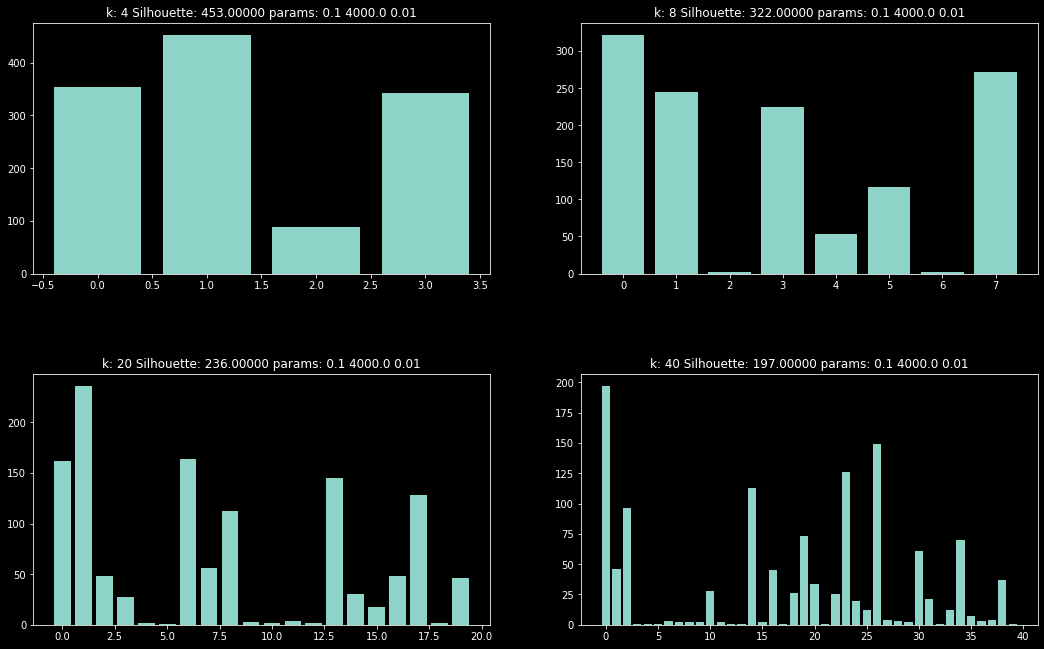

In [12]:
import matplotlib.pyplot as plt

plt.style.use('dark_background')

def plot_histograms():
    plt.figure(figsize=(18, 24))
    plt.subplots_adjust(hspace=0.4)
    cnt = 1
    for k in histograms:
        plt.subplot(len(histograms), 2, cnt)
        cnt += 1
        d = histograms[k]
        plt.bar(d.keys(), d.values())
        plt.title('k: ' + str(k) + ' Biggest: ' + str(min_k[k]) + parameters[k])

plot_histograms()

In [13]:
save_results('clusters/profiles/')